In [81]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D
from tensorflow.keras.models import Model, save_model
from scipy.fftpack import fft2, ifft2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Load in the hologram data

In [2]:
ds = xr.open_dataset("../../synthetic_holograms_v01.nc")

Split into training and testing data

In [6]:
split_index = 7000
all_labels = ds[["x", "y", "z", "d"]].to_dataframe()
train_labels = all_labels.iloc[:split_index]
test_labels = all_labels.iloc[split_index:]
scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

Information about the image variable

In [7]:
in_data = ds["image"]

In [4]:
ds["image"].dims

('hologram_number', 'xsize', 'ysize')

Rescale the imagery from 0 to 1 since 255 is the largest value.

In [8]:
scaled_in_data = in_data.astype(np.float16) / 255

In [60]:
scaled_in_data.dtype

dtype('float16')

In [63]:
conv_input = Input(shape=(600, 400, 1))
conv_1 = Conv2D(8, (5, 5), padding="same")(conv_input)
act_1 = Activation("relu")(conv_1)
pool_1 = MaxPool2D(pool_size=(4, 4))(act_1)
conv_2 = Conv2D(16, (5, 5), padding="same")(pool_1)
act_2 = Activation("relu")(conv_2)
pool_2 = MaxPool2D(pool_size=(4, 4))(act_2)
conv_3 = Conv2D(32, (5, 5), padding="same")(pool_2)
act_3 = Activation("relu")(conv_3)
pool_3 = MaxPool2D(pool_size=(4, 4))(act_3)
flat = Flatten()(pool_3)
dense_1 = Dense(64, activation="relu")(flat)
dense_2 = Dense(32, activation="relu")(dense_1)
out = Dense(4)(dense_2)
mod = Model(conv_input, out)
mod.compile(optimizer=Adam(lr=0.001), loss="mae")
mod.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 600, 400, 1)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 600, 400, 8)       208       
_________________________________________________________________
activation_12 (Activation)   (None, 600, 400, 8)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 150, 100, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 150, 100, 16)      3216      
_________________________________________________________________
activation_13 (Activation)   (None, 150, 100, 16)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 25, 16)        0   

In [64]:
mod.fit(np.expand_dims(scaled_in_data[:split_index].values, axis=-1), scaled_train_labels.values, batch_size=32, epochs=20, verbose=1)

Train on 7000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.2561
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.1898
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.1340
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.1117
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0945
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0854
Epoch 7/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0773
Epoch 8/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0749
Epoch 9/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0694
Epoch 10/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0645
Epoch 11/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0560
Epoch 12/20
7000/7000 [=================

In [70]:
preds_out = mod.predict(np.expand_dims(scaled_in_data.values, axis=-1), batch_size=64)

In [109]:
save_model(mod, "holodec_cnn.h5", save_format="h5")

In [71]:
preds_original = scaler.inverse_transform(preds_out)

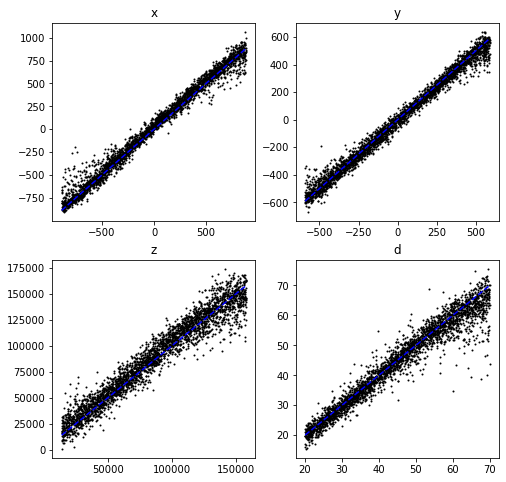

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, ax in enumerate(axes.ravel()):
    ax.scatter(test_labels.iloc[:, a], preds_original[split_index:, a], 1, 'k')
    diag = np.linspace(test_labels.iloc[:, a].min(), test_labels.iloc[:, a].max(), 10)
    ax.plot(diag, diag, 'b--' )
    ax.set_title(test_labels.columns[a])
plt.savefig("error_hist.png", dpi=200, bbox_inches="tight")

In [ ]:
2000 / 

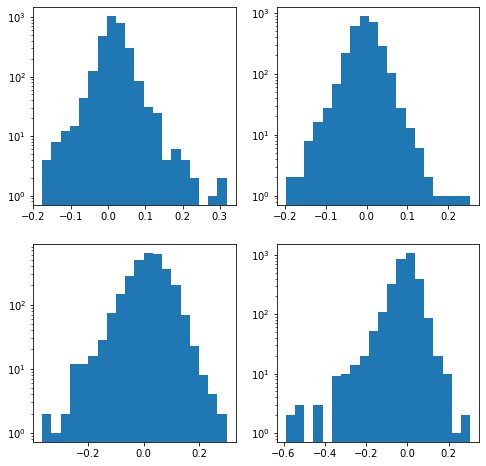

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, ax in enumerate(axes.ravel()):
    ax.hist( (preds_original[split_index:, a] - test_labels.iloc[:, a].values) / (test_labels.iloc[:, a].max() - test_labels.iloc[:, a].min()),
           bins=20)
    ax.set_yscale("log")

In [74]:
np.mean(np.abs(preds_original[split_index:] - test_labels.values), axis=0)

array([5.2545212e+01, 3.0758013e+01, 7.9830908e+03, 2.2729902e+00],
      dtype=float32)

In [75]:
np.mean(np.abs(preds_out[split_index:] - scaled_test_labels.values), axis=0)

array([0.02964406, 0.02604717, 0.05544508, 0.04548431])

In [81]:
scaled_test_labels.iloc[index, 0:2]

x    0.945862
y    0.435532
Name: 9343, dtype: float64

In [92]:
preds_out.shape

(10000, 4)

In [77]:
errors = preds_out[split_index:] - scaled_test_labels.values
errors.sum(axis=1).argsort()[::-1][:10]

array([1219, 1338,  902, 2511,  147, 2923, 1501, 2690, 1155, 1193])

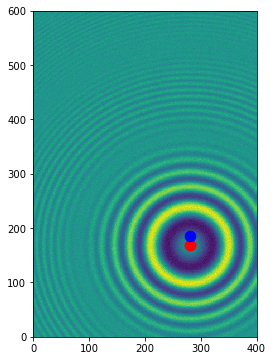

In [92]:
index = 12
plt.figure(figsize=(4, 6))
plt.pcolormesh(scaled_in_data[split_index + index])
plt.scatter(scaled_test_labels.iloc[index, 1] * 400, scaled_test_labels.iloc[index, 0] * 600, 2 * test_labels.iloc[index, -1], 'r')
plt.scatter(preds_out[split_index + index, 1] * 400, preds_out[split_index + index, 0] * 600, 2 * preds_original[split_index + index, -1], 'b')

In [95]:
fout = ifft2(scaled_in_data[split_index + index])


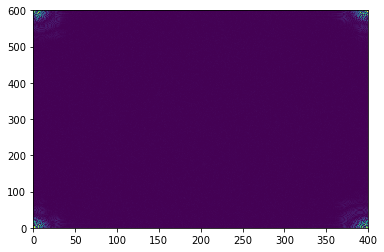

In [101]:
plt.pcolormesh(np.abs(fout.imag))

In [99]:
fout.real.min()

-0.0011918849